# N04. Proyección de oferta de energía hidráulica (ofertaEnergiaHidro)
Se realizará la proyección de 'Aportes de energía hidráulica (energía)' para los próximos 78 meses.
Esta proyección se basará en lo siguiente:

* Se encontrará la relación entre 'Aportes de energía hidráulica (energía)' y 'Aportes de energía hidráulica (caudal)'.
* Se contrará la relación y la 'Diferencia de aportes' entre los 'Aportes de energía hidráulica históricos' y 'Aportes de energía hidráulica real'.
* Se encontrará la relación entre el MEI y la 'Diferencia de aportes'.

Se crearán inicialmente dos DataFrame: 'aportes' y 'capacidad'.

## 4.1. Carga paquetes para la proyección 

In [1]:
#*******************************************************************************       
# 4.1.1. Carga paquetes requeridos para leer en base de datos y proyección.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget

## 4.2. Aportes de caudales y energía de caudales
El DataFrame 'aportes' incluirá las siguientes variables, las cuales se transformarán en variables mensuales:
* AporEner
* AporEnerMediHist
* AporCaudalRio
* AporCaudalMediHistRio

* AporCaudalRio (m3/s). Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo.

* AporCaudalMediHistRio (m3/s). Caudal medio mensual histórico para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles.

* AporEner (kWh). Caudales en energia de los rios que aportan agua a algun embalse del SIN (Sistema).

* AporEnerRio (kWh). Caudales en energia de los rios que aportan agua a algun embalse del SIN (Río).

* AporEnerMediHist	Aportes Media Histórica Energía	Sistema

* AporEnerMediHist (kWh). Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles (Sistema).

* AporCaudalMediHistRio (kWh). Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles (Río).


In [4]:
#*******************************************************************************       
# 4.2.1. Crea la máquina para conectarse a la base de datos dbXm.db.
#*******************************************************************************
engine = create_engine('sqlite:///dbXm.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()

In [71]:
#*******************************************************************************       
# 4.2.2. Lee las variables de 'aportes' y ajusta.
#*******************************************************************************
tablas = ['AporEner', 'AporEnerMediHist', \
    'AporEnerRio', 'AporEnerMediHistRio', \
        'AporCaudalRio', 'AporCaudalMediHistRio']
nombresDf = ['aporEner', 'aporEnerMediHist', \
    'aporEnerRio', 'aporEnerMediHistRio', \
        'aporCaudalRio', 'aporCaudalMediHistRio']
df = {}

for i, tabla in  enumerate(tablas):
    consulta = "SELECT * FROM " + tabla
    df[nombresDf[i]] = pd.read_sql(consulta, engine, parse_dates=["Date"])
#Ajusta las columnas, los índices y los nombres de los DataFrames.
for i, nombre in  enumerate(nombresDf):
   df[nombre] = df[nombre].iloc[:, 1:] if i <= 1 else df[nombre].iloc[:, [1, 3]]
   df[nombre] = df[nombre].set_index('Date')
   df[nombre].columns = [nombre]
   df[nombre + '_m'] = df[nombre] #Crea los contenedores DataFrame mensuales.

In [72]:
#*******************************************************************************       
# 4.2.3. Agrupa los valores para obtener los valores de mensuales.
#*******************************************************************************
for i, nombre in  enumerate(nombresDf):
    if i <= 1: #Diarios, por Sistema.
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby(pd.to_datetime(df[nombre + '_m'].index)\
                .to_period('M')).mean()
    else: #Diarios, por ríos.
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby(pd.to_datetime(df[nombre + '_m'].index).\
                to_period('D')).sum()
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby((df[nombre + '_m'].index)\
                .to_timestamp().to_period('M')).mean()
    #
    df[nombre + '_m'].index = df[nombre + '_m'].index.to_timestamp()


In [117]:
#*******************************************************************************       
# 4.2.4. Integra las tablas de base de datos en un DataFrame aportes_m.
#*******************************************************************************
# # aportes_m = df['aporEner_m']/1e6
# nombresDf_m = ['aporEnerMediHist_m', \
#     'aporEnerRio_m', 'aporEnerMediHistRio_m', \
#         'aporCaudalRio_m', 'aporCaudalMediHistRio_m']
# for i, nombre in enumerate(nombresDf_m):
#     if i == 0:
#         aportes_m = pd.merge(aportes_m, df[nombre]/1e6, left_on="Date", right_on="Date")
#     else:
#         aportes_m = pd.merge(aportes_m, df[nombre], left_on="Date", right_on="Date")

# aportes_m = aportes_m.drop(columns=['aporEnerRio', 'aporEnerMediHistRio'])
# aportes_m.insert(loc=len(aportes_m.columns), column="diferenciaAportes", \
#     value=(aportes_m['aporEner'] - aportes_m['aporEnerMediHist']).values, \
#         allow_duplicates=True)

In [2]:
#*******************************************************************************
# 4.2.5. Salva  y lee aportes_m.
#*******************************************************************************
#Salva pbmCpe
# aportes_m.to_parquet('parquet/aportes_m.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee pbmCpe
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

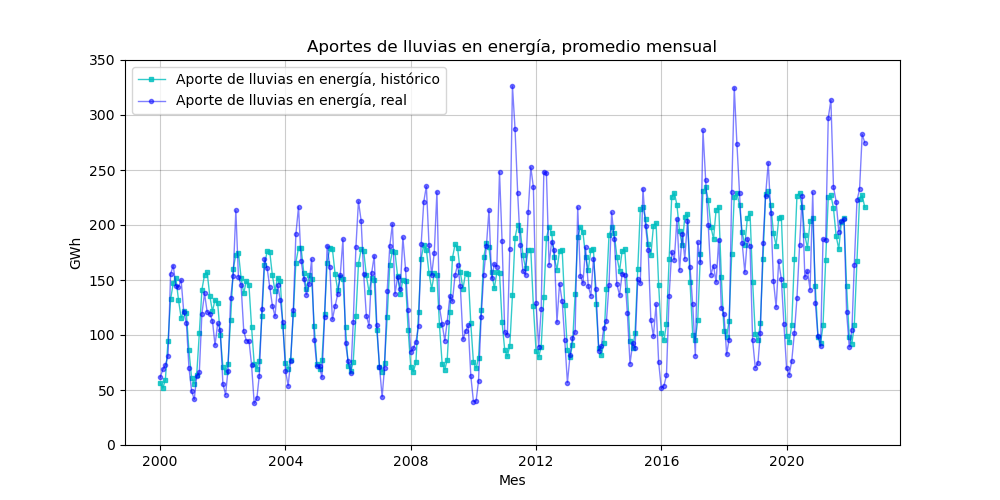

In [91]:
#*******************************************************************************
# 4.2.6. Grafica aportes_m.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de lluvias en energía, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.aporEnerMediHist/1e6, 'c-s', \
    label='Aporte de lluvias en energía, histórico', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_m.index, aportes_m.aporEner/1e6, 'b-o', \
    label='Aporte de lluvias en energía, real', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

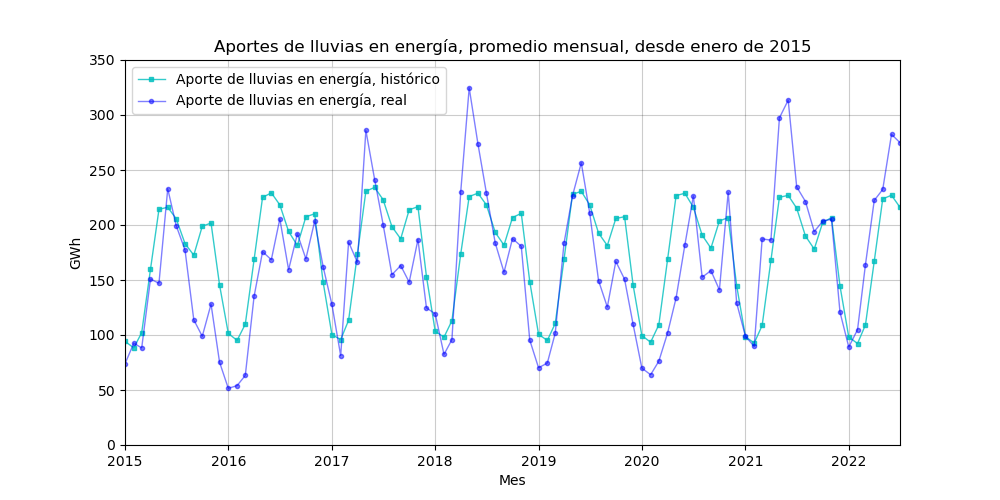

In [93]:
#*******************************************************************************
# 4.2.7. Grafica aportes_m desde 2015-01.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de lluvias en energía, promedio mensual, desde enero de 2015')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.aporEnerMediHist/1e6, 'c-s', \
    label='Aporte de lluvias en energía, histórico', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_m.index, aportes_m.aporEner/1e6, 'b-o', \
    label='Aporte de lluvias en energía, real', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

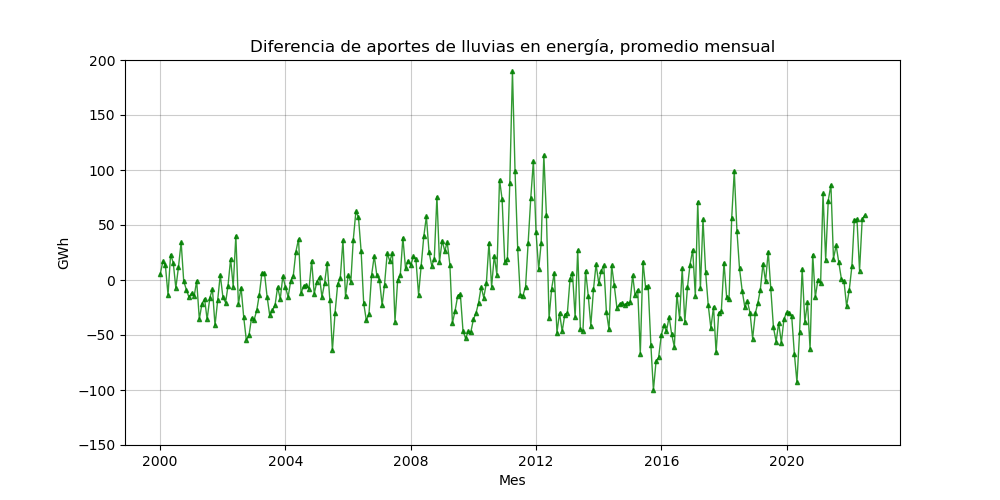

In [125]:
#*******************************************************************************
# 4.2.8. Grafica diferencia de aportes de lluvia, promedio mensual.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Diferencia de aportes de lluvias en energía, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.diferenciaAportes, 'g-^', \
    label='Diferencia de aporte de lluvias en energía', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(-150, 200)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

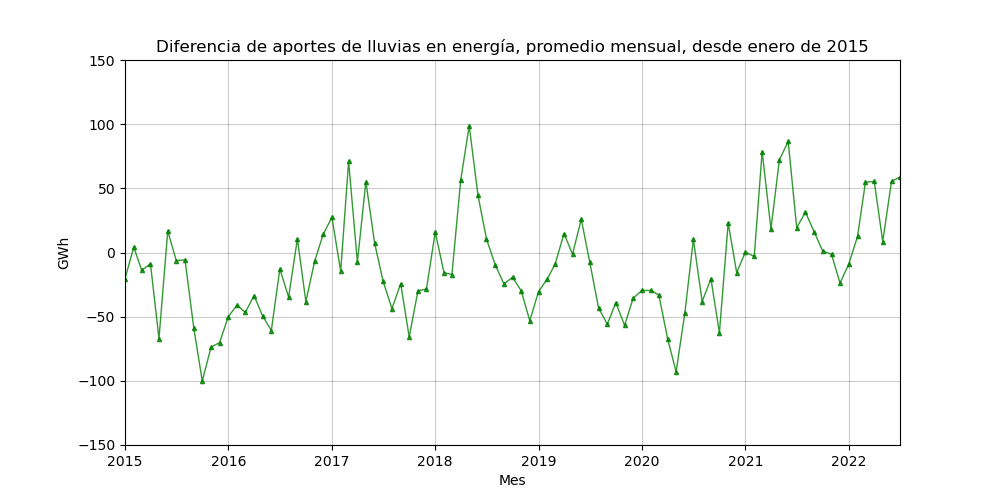

In [130]:
#*******************************************************************************
# 4.2.9. Grafica diferencia de aportes de lluvia, desde enero de 2015.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Diferencia de aportes de lluvias en energía, promedio mensual, desde enero de 2015')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.diferenciaAportes, 'g-^', \
    label='Diferencia de aporte de lluvias en energía', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(-150, 150)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

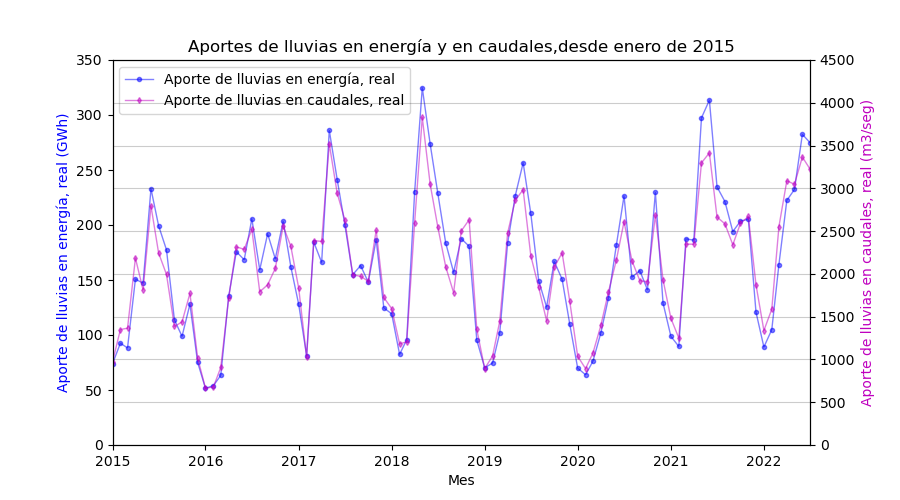

In [3]:
#*******************************************************************************
# 4.2.10. Grafica aporEner Vs aporCaudalRio desde 2015-01.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
ax2 = ax1.twinx()

ax1.set_title ('Aportes de lluvias en energía y en caudales,desde enero de 2015')

ax1.set_xlabel("Mes")
ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
ax2.set_ylabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')

linea1 = ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label="Aporte de lluvias en energía, real", \
        linewidth=1, markersize=3, alpha=0.5)

linea2 = ax2.plot(aportes_m.index, aportes_m.aporCaudalRio, 'm-d', \
    label="Aporte de lluvias en caudales, real", linewidth=1, \
        markersize=3, alpha=0.5)


# added these three lines
lineas = linea1 + linea2
etiquetas = [l.get_label() for l in lineas]
ax1.legend(lineas, etiquetas, loc='best')

plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
#plt.ylim(0, 400)
#plt.par.ylim(0, 400)
ax1.set_ylim(0, 350)
ax2.set_ylim(0, 4500)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [ ]:
#*******************************************************************************
# 4.2.11. Calcula el coeficiente de correlación entre aporCaudalRio Vs aporEner.
#*******************************************************************************
import scipy.stats
# aportes_m.aporCaudalRio.corr(aportes_m.aporEner) #0.9375
r, p = scipy.stats.pearsonr(aportes_m.aporCaudalRio, aportes_m.aporEner)
r, p # r (correlación de Pearson): 0.9375; valor p: 0.
#(0.9375748320891986, 2.1212045210040593e-125)

In [ ]:
#*******************************************************************************
# 4.2.12. Calcula la regresión entre la dispersión de aporCaudalRio Vs aporEner.
#*******************************************************************************
# m, b = np.polyfit(aportes_m.aporCaudalRio, aportes_m.aporEner, 1)
# aportes_m.insert(5, 'aporEner_hat', aportes_m.aporCaudalRio*m + b, allow_duplicates=True) 
# aportes_m
# m, b
# m = 0.08577574033953389
# b = -5.7997463853853946
# m * X + b

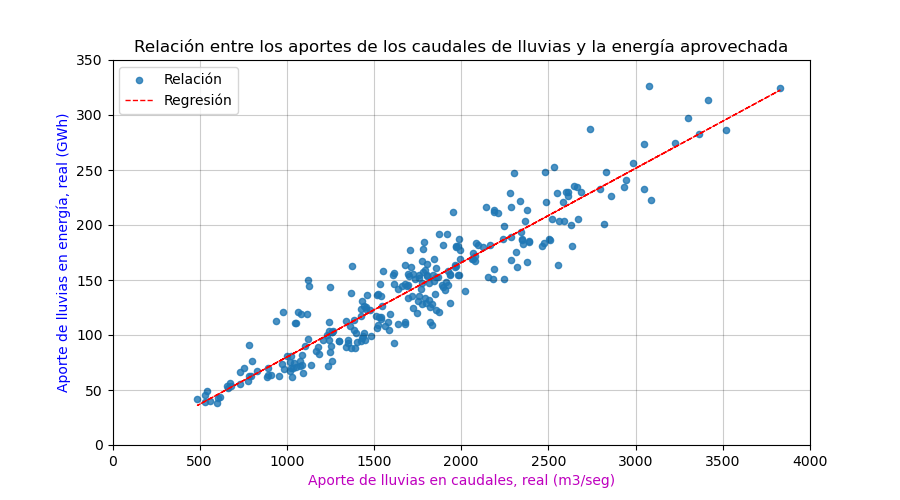

In [44]:
#*******************************************************************************
# 4.2.12. Grafica dispersión de aporCaudalRio Vs aporEner con la regresión.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.

ax1.set_title ('Relación entre los aportes de los caudales de lluvias y la energía aprovechada')

# ax1.set_xlabel("Mes")
# ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# ax2.set_ylabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')

plt.scatter(aportes_m.aporCaudalRio, aportes_m.aporEner, label='Relación', \
    alpha=0.8, s=20, marker="o")
ax1.plot(aportes_m.aporCaudalRio, aportes_m.aporEner_hat, 'r--', \
    label='Regresión', linewidth=1)
plt.xlabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')
plt.ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 350)
plt.xlim(0, 4000)
# plt.par.ylim(0, 400)
#plt.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.legend(loc='best')
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

La relación es: aporEner = (aporCaudalRio * 0.0857) - 5.799 

## 4.3. Relación entre el MEI  y los 'Aportes de caudales de lluvia reales' 